# Grade: /100 points

# Assignment 01: Supervised learning, Linear models, and Loss functions

In this assignment, you're going to write your own methods to fit a linear model using either an OLS or LAD cost function.  

## Data set 

For this assignment, we will examine some data representing possums in Australia and New Guinea. The data frame contains 46 observations on the following 6 variables:

* sex: Sex, either m (male) or f (female).
* age: Age in years.
* headL: Head length, in mm.
* skullW: Skull width, in mm.
* totalL: Total length, in cm.
* tailL: Tail length, in cm.

## Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


## Preliminaries

In [1]:
# Import all the necessary packages: 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as ss 
import scipy.optimize as so
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline


## Part 1
### Question 1.1:  /10 points


Read in the `possum.csv` file as a `pandas.DataFrame`.  Investigate the relationship between the possum's age and it's tail length by plotting a scatter plot of the `age` and `tailL` columns. You might want to add an `alpha` in case some data are overlapping. 

Text(0, 0.5, 'Possum Tail Length')

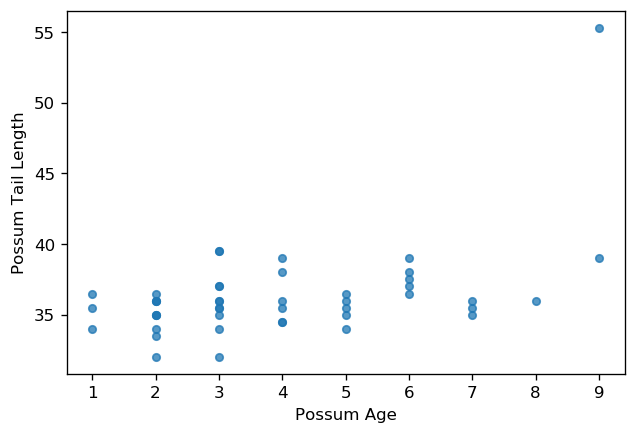

In [10]:
# Read in the data with pandas
possum_data = pd.read_csv('possum.csv')

# Create the axis where the plotting will happen
fig, ax = plt.subplots(dpi=120)
# Do the plotting
possum_data.plot.scatter(x='age', y='tailL',alpha = 0.75, ax = ax);
# Adjust the labels
ax.set_xlabel('Possum Age')
ax.set_ylabel('Possum Tail Length')


### Question 1.2: /5 point

Recall that the linear model, we obtain predictions by computing 

$$ \hat{\mathbf{y}} = \mathbf{X} \beta $$

Here, $\mathbf{X}$ is a design matrix which includes a column of ones, $\beta$ are coefficients, and $\mathbf{y}$ are outcomes.  Write a function `linearModelPredict` to compute linear model predictions given data and a coefficient vector.  The function should take as it's arguments a 1d-array of coefficients `b` and the design matrix `X` as a 2d-array and return linear model predictions `yp`.

Test the function by setting 

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
```
and call you function with these values! 

Report $\hat{\mathbf{y}}$. 
What is the dimensionality of the numpy-array that you get back? 

Hint:  Read the documentation for `np.dot` or the `@` operator in `numpy`.

In [11]:
def linearModelPredict(b,X):
    # Numpy does matrix multiplication in a few ways.
    # The dot or @ operator are most common.
    # b should always have the same dimensionality as X has columns.
    yp = X@b

    return yp

# Test 
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
print("X@b is \n ", linearModelPredict(b,X))




X@b is 
  [ 0.1 -0.2  0.7]


In [12]:
# Note that b can either be a 2d array or a 1d array and the mulitplication will still work
# This requires you to be cognizant about shapes and keep track of the dimension.
# Here are some examples

# b is a 2d array
print('Using a 2d array...')
X = np.eye(2)
b = 2*np.ones(2).reshape(-1,1)

print("X looks like:\n", X)
print("b looks like:\n", b)
#Note, the result of this multiplication is a 2d array
print("X@b is \n ", linearModelPredict(b,X))


# b is a 1d array
print('\n\nUsing a 1d array...')
X = np.eye(2)
b = 2*np.ones(2)

print("X looks like:\n", X)
print("b looks like:\n", b)
#Note, the result of this multiplication is a 1d array
print("X@b is \n ", linearModelPredict(b,X))




Using a 2d array...
X looks like:
 [[1. 0.]
 [0. 1.]]
b looks like:
 [[2.]
 [2.]]
X@b is 
  [[2.]
 [2.]]


Using a 1d array...
X looks like:
 [[1. 0.]
 [0. 1.]]
b looks like:
 [2. 2.]
X@b is 
  [2. 2.]


### Question 1.3: /15 points

Write a function `linearModelLossRSS` which computes and returns the loss function for an OLS model parameterized by $\beta$, as well as the gradient of the loss.  The function should take as its first argument a 1d-array `beta` of coefficients for the linear model, as its second argument the design matrix `X` as a 2d-array, and as its third argument a 1d-array `y` of observed outcomes.

Test the function with the values 

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
```

Report RSS and gradient. 
Written answer: To minimize the cost do you need increase or decrease the value of the parameters? 

In [13]:
def linearModelLossRSS(b,X,y):
    # The loss is really a function of b.  The b changes, the X and y stay fixed.
    # Make predictions
    predY = linearModelPredict(b,X)
    # Compute residuals.  This is an array.  The dimension of res will depend on if
    # b is 1d or 2d.  If b is 2d, predY will be 2d, and so res will be 2d due to something
    # called "array broadcasting".
    res = y-predY
    # Simply sum up the squared residuals.  This is the value of our loss.
    residual_sum_of_squares = sum(res**2) 
    # Because res is a vector, we can take the product of res with X.
    # Since X is two dimensional because it is a design matrix, this results in a
    # 2d array.  The gradient has two elements because there are two parameters.
    gradient=-2*(res @ X)

    return (residual_sum_of_squares, gradient)

X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
rss, grad =linearModelLossRSS(b,X,y)

print("RSS is", rss)
print("gradient:\n", grad)

RSS is 2.06
gradient:
 [-3.6 -4. ]


The gradient is negative for both parameters, therefore both need to be increased to minimize the cost. 

### Question 1.4:  /15 points. 

Now that you've implemented a loss function in question 3, it is now time to minimize it!

Write a function `linearModelFit` to fit a linear model.  The function should take as its first argument the design matrix `X` as a 2d-array, as its second argument a 1d-array `y` of outcomes, and as its third argument a function  `lossfcn` which returns as a tuple the value of the loss, as well as the gradient of the loss. As a result, it should return the estimated betas and the R2. 

Test the function with the values: 
```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
```

Report best parameters and the fitted R2 


In [14]:
def linearModelFit(X,y,lossfcn = linearModelLossRSS):
    # Because we know b has to have the some dimension as X has columns,
    # We can use the number of columns to determine the size of betas
    # In this case, we use a 2d array
    nrows,ncols = X.shape
    betas=np.zeros((ncols,1))
    # Optimize the loss
    RES = so.minimize(lossfcn,betas,args=(X,y),jac=True)
    # Obtain estimates from the optimizer
    estimated_betas=RES.x 
    # Compute goodness of fit.
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = linearModelLossRSS(estimated_betas,X,y)
    R2 = 1-RSS/TSS 

    return (estimated_betas,R2)


X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
beta , R2 = linearModelFit(X,y)

print("Betas are", beta)
print("R2:\n", R2)

Betas are [0.6 0.6]
R2:
 0.75


### Question 1.5: /15 points

Use the above functions to fit your model to the possum data. Then use your model and the fitted parameters to make predictions along a grid of equally spaced possum ages.  

Plot the data and add a line for the predicted values. You can get these by generating a new X-matrix with equally space ages (using for example np.linspace). Also report the R2 value for the fit. 


Text(0.25, 0.8, 'R Squared: 0.22')

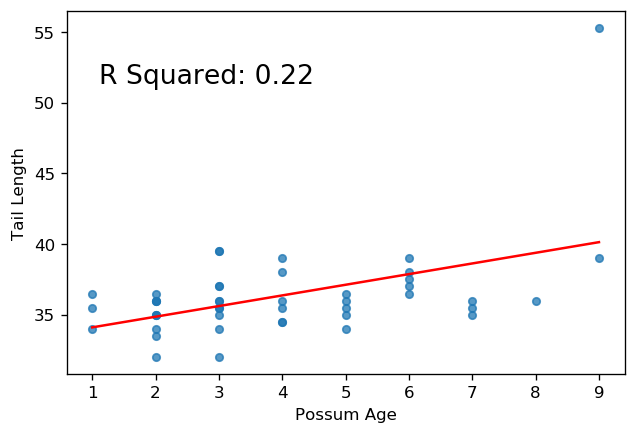

In [15]:
# Fit the data 
y = possum_data.tailL.values
age = possum_data.age.values
N = age.size
X = np.c_[np.ones(N), age]
betas, R2 = linearModelFit(X,y)

# Create new data
age_grid = np.linspace(age.min(), age.max(),10)
# Turn it into a design matrix
Xn = np.c_[np.ones(age_grid.size), age_grid]
# Compute predictions with the new data and estimated coefficients
yn = linearModelPredict(betas, Xn)

fig, ax = plt.subplots(dpi = 120)
possum_data.plot.scatter(x='age', y='tailL', alpha=0.75, ax=ax)
ax.set_xlabel('Possum Age')
ax.set_ylabel('Tail Length')

ax.plot(age_grid, yn, color = 'red')
ax.annotate('R Squared: {R2}'.format(R2=R2.round(2)), 
            xy=(0.25, 0.8), 
            xycoords='axes fraction',
            ha='center',
            fontsize = 16)



## Part 2: LAD Regression

### Question 2.1:  /15 points

In the previous section, we worked with the squared loss.  Now, we'll implement a linear model with least absolute deviation loss.

Write a function `linearModelLossLAD` which computes the least absolute deviation loss function for a linear model  parameterized by $\beta$, as well as the gradient of the loss.  The function should take as its first argument a 1d-array `beta` of coefficients for the linear model, as its second argument the design matrix `X` as a 2d-array, and as its third argument a 1d-array `y` of observed outcomes.

Test the function with the values 

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
```

Report RSS and gradient. 

In [16]:
def linearModelLossLAD(b,X,y):
    # Same concept as before, different loss
    predY = linearModelPredict(b,X)
    res = y-predY
    sres = np.sign(res); 
    sum_abs_dev = sum(abs(res))
    # Note the gradients are computed using the sign of the residuals
    grad =- (sres @ X)

    return (sum_abs_dev,grad)

X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2]) 
lad, grad =linearModelLossLAD(b,X,y)

print("LAD is", lad)
print("gradient:\n", grad)

LAD is 2.0
gradient:
 [-1. -1.]


### Question 2.2: /10 points


Use the above functions to fit your LAD model. Use your model to make predictions along a grid of equally spaced possum ages.  Once fit, add the fitted line to the scatter plot as in question 1.5.  Also report the R2-value. 

Written answer: What is the difference in the fit obtained with an L1 as compared to the L2 cost function? Which one has a higher R2 value? Why?  

Note: If you recieve an error from the optimizer, it may be because the loss function for the LAD model is not differentiable at its minimum.  This will lead to some gradient based optimiers to fail to converge.  If this happens to you then pass `method="Powell"` to `scipy.optimize.minimize`.



Text(0.25, 0.8, 'R Squared: 0.13')

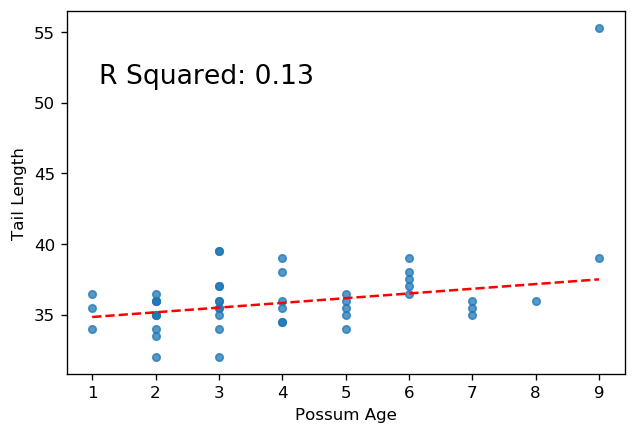

In [17]:
# Same as above
y = possum_data.tailL.values
age = possum_data.age.values
N = age.size
X = np.c_[np.ones(N), age]
betas, R2 = linearModelFit(X,y, lossfcn=linearModelLossLAD)

age_grid = np.arange(age.min(), age.max()+1)
Xn = np.c_[np.ones(age_grid.size), age_grid]
yn = linearModelPredict(betas, Xn)

fig, ax = plt.subplots(dpi = 120)
possum_data.plot.scatter(x='age', y='tailL', alpha=0.75, ax=ax)
ax.set_xlabel('Possum Age')
ax.set_ylabel('Tail Length')

ax.plot(age_grid, yn, color = 'red', linestyle = '--')
ax.annotate('R Squared: {R2}'.format(R2=R2.round(2)), 
            xy=(0.25, 0.8), 
            xycoords='axes fraction',
            ha='center',
            fontsize = 16)


Written answer: The LAD fit does not give as much weight to the outlier (9,55) as the OLS fit. The R2 value is lower, however. This is because OLS minimized the RSS, and therefore maximizes R2.  

### Question 2.3: /15 points

Fit both an OLS model and a LAD model with `statsmodels`.  In no more than two sentences, comment on the rsquared values from `statsmodels` and the rsquared values from your models. Are they similar?

OLS rsquared:  0.22
LAD rsquared:  nan


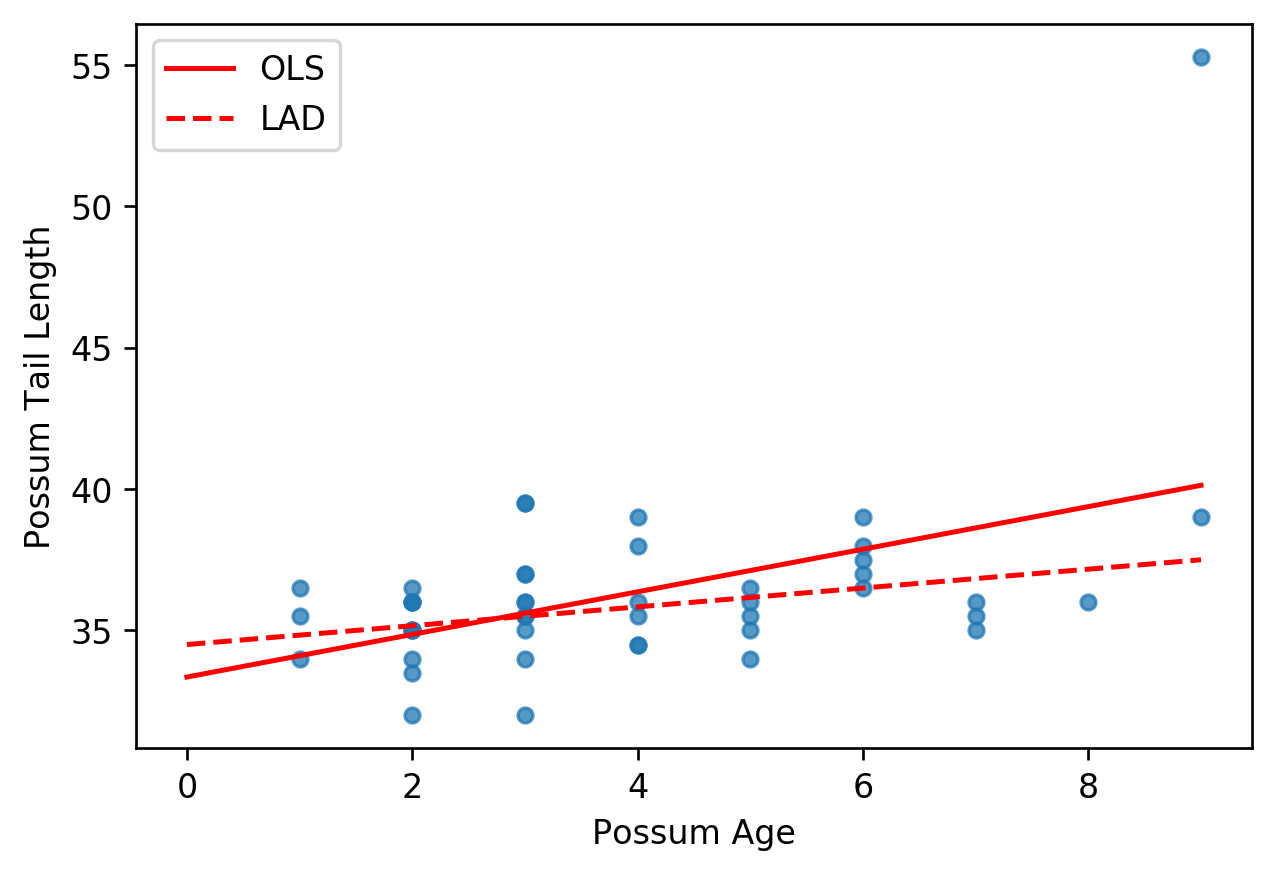

In [18]:
# Biggest problem here is that people did not show their model the same type of data.
# When you make predctions on new data, that new data needs to be in the same format
# as the training data.

# Here, I am showing my models a dataframe.
ols_fit = smf.ols('tailL~age', data = possum_data).fit()
lad_fit = smf.quantreg('tailL~age', data = possum_data).fit(q = 0.5)

print('OLS rsquared: ', ols_fit.rsquared.round(2))
print('LAD rsquared: ', lad_fit.rsquared)


age = np.linspace(0,9,101)
# So my new data needs to be in the format of a dataframe
new_df = pd.DataFrame({'age':age})
y_ols = ols_fit.predict(new_df).values
y_lad = lad_fit.predict(new_df).values



fig, ax = plt.subplots(dpi = 120)
possum_data.plot.scatter(x = 'age', y ='tailL', ax = ax, alpha = 0.75)
ax.plot(age, y_ols, color = 'red', label = 'OLS')
ax.plot(age, y_lad, color = 'red', linestyle = 'dashed', label = 'LAD')
ax.set_xlabel('Possum Age')
ax.set_ylabel('Possum Tail Length')
ax.legend()

